In [12]:
import glob
import numpy as np
import pandas as pd
from zipfile import ZipFile
import bz2
import h5netcdf
import xarray as xr
import netCDF4 as nc
import os, sys

from collections import defaultdict
from ipywidgets import IntProgress
from IPython.display import display

sys.path.append(os.getcwd()+'/../resort/rasotools-master/')
import rasotools

sys.path.append(os.path.expanduser("~")+'/uvpy/')
import uvfunctions as uvf
import uvplot as uvp
import uvtests as uvt

import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['figure.figsize'] = (20, 10)
font = {'size'   : 20}
matplotlib.rc('font', **font)

from ipywidgets import IntProgress
from IPython.display import display
from IPython.display import Image

In [4]:
import ray
# import time
ray.init(num_cpus=70)

2023-08-17 15:16:39,950	INFO worker.py:1528 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.10.6', ray_version='2.1.0', ray_commit='be49bde7ee4f6adb3f8710aee0665c27f9f0bb62', address_info={'node_ip_address': '131.130.157.5', 'raylet_ip_address': '131.130.157.5', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2023-08-17_15-16-37_807908_2512026/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2023-08-17_15-16-37_807908_2512026/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2023-08-17_15-16-37_807908_2512026', 'metrics_export_port': 62593, 'gcs_address': '131.130.157.5:62336', 'address': '131.130.157.5:62336', 'dashboard_agent_listen_port': 52365, 'node_id': '5bb32f29f7e6a4c7aa39f7868d70f417c0b2d792f5a330b21d5e5b73'})

In [5]:
@ray.remote
def calc_trend(file, dt_from, dt_to, plev):
    print(file)
    sys.path.append(os.getcwd() + "/../resort/rasotools-master/")
    import rasotools

    sout = {}

    temp = pd.read_csv(file, low_memory=False)

    sout['station'] = file
    sout['start'] = np.nanmin(temp.date_of_observation)
    sout['end'] = np.nanmax(temp.date_of_observation)
    sout['obs'] = len(temp)
    try:
        sout['lat'] = float(temp[~np.isnan(temp.latitude)].latitude.iloc[0])
        sout['lon'] = float(temp[~np.isnan(temp.longitude)].longitude.iloc[0])
    except:
        sout['lat'] = 999
        sout['lon'] = 999
    
    temp["time"] = pd.to_datetime(temp["date_of_observation"], format='%Y-%m-%d%H:%M:%S+%f') # 2011-06-0112:00:00+00
    temp = temp[temp.press == plev]
    temp = temp[np.logical_and((temp.time >= dt_from), (temp.time <= dt_to))]
    if len(temp) < (19 * 365):
        for i in ['rh', 'temp', 'u', 'v', 'rh_h', 'temp_h', 'u_h', 'v_h']:
            sout[i] = np.nan
        return sout            
    
    for var in ['rh', 'temp', 'u', 'v']:
        # drop the 1st and 99th percentile
        q_01 = temp[var].quantile(
            0.01
        )  # get the 1st percentile value
        q_99 = temp[var].quantile(
            0.99
        )  # get the 99th percentile value
        temp = temp[
            (temp[var] > q_01) & (temp[var] < q_99)
        ]
        if len(temp) > 0:
            # temp.sort_values('time')
            try:
                temp["latitude"] = np.array([sout['lat']] * len(temp))
                temp["longitude"] = np.array([sout['lon']] * len(temp))
            except:
                temp["latitude"] = np.array([999] * len(temp))
                temp["longitude"] = np.array([999] * len(temp))
            temptime = temp.time
            if len(temp) >= 19 * 365 and len(np.unique(temptime.dt.year)) > 19:
                xa = temp.set_index(["latitude", "longitude", "time"]).to_xarray()
                out = rasotools.met.time.trend(
                    xa[var], only_slopes=True, method="polyfit"
                ).values[0,0]
                sout[var] = out * 3650
                out_adj = rasotools.met.time.trend(
                    xa[var+'_h'], only_slopes=True, method="polyfit"
                ).values[0,0]
                sout[var+'_h'] = out_adj * 3650
            else:
                sout[var] = np.nan
                sout[var+'_h'] = np.nan
        else:
            sout[var] = np.nan
            sout[var+'_h'] = np.nan
    
    return sout

In [6]:
for dt in [("1993-01-01", "2022-12-31"), ("1973-01-01", "2002-12-31"), ("1958-01-01", "1987-12-31")]:
    dt_from = np.datetime64(dt[0])
    dt_to = np.datetime64(dt[1])
    plev = 70000
    result_ids = []
    files = glob.glob('/users/staff/uvoggenberger/scratch/RHARM_2/cleaned*.csv')

    for file in files:
        result_ids.append(calc_trend.remote(file, dt_from, dt_to, plev))

    results = ray.get(result_ids)
    
    dd = defaultdict(list)

    for d in results: # you can list as many input dicts as you want here
        for key, value in d.items():
            dd[key].append(value)
    
    df = pd.DataFrame.from_dict(results)
    df.to_csv('./polyfit_trends_'+ str(plev) +'_RHARM_2_'+dt[0]+'_'+dt[1]+'_.csv')
ray.shutdown()

(calc_trend pid=2521059) /users/staff/uvoggenberger/scratch/RHARM_2/cleaned_AGM00060630.csv
(calc_trend pid=2521079) /users/staff/uvoggenberger/scratch/RHARM_2/cleaned_ASM00094767.csv
(calc_trend pid=2521067) /users/staff/uvoggenberger/scratch/RHARM_2/cleaned_ASM00094647.csv
(calc_trend pid=2521070) /users/staff/uvoggenberger/scratch/RHARM_2/cleaned_ARM00087047.csv
(calc_trend pid=2521024) /users/staff/uvoggenberger/scratch/RHARM_2/cleaned_ARM00087576.csv
(calc_trend pid=2521025) /users/staff/uvoggenberger/scratch/RHARM_2/cleaned_BNM00065330.csv
(calc_trend pid=2521027) /users/staff/uvoggenberger/scratch/RHARM_2/cleaned_ASM00094302.csv
(calc_trend pid=2521029) /users/staff/uvoggenberger/scratch/RHARM_2/cleaned_ASM00094299.csv
(calc_trend pid=2521028) /users/staff/uvoggenberger/scratch/RHARM_2/cleaned_ASM00094294.csv
(calc_trend pid=2521030) /users/staff/uvoggenberger/scratch/RHARM_2/cleaned_AYM00089664.csv
(calc_trend pid=2521036) /users/staff/uvoggenberger/scratch/RHARM_2/cleaned_AGM0

In [15]:
def show_trend_map(file, var, label, c_bar):
    plev = file.split('_')[-6]
    sdate = file.split('_')[-3]
    edate = file.split('_')[-2]
    good_results = {}
    good_results['lat'] = []
    good_results['lon'] = []
    good_results['st'] = []
    good_results['at'] = []
    good_results['label'] = []
    results = pd.read_csv(file)
    results = results[~np.isnan(results[var])]
    statnum = len(results)

    a = rasotools.plot._helpers.cost(np.asarray(results.lon), np.asarray(results.lat), np.asarray(results[var]))
    cost = np.sum(a)/len(a)
    fig1 = uvp.world_map_plot(results[var], results.lat, results.lon, results.station, label + ' trend unadjusted <br> '+str(plev)+'_'+sdate+'_'+edate+' <br> heterogeneity cost: ' + str(cost), show = False, mid = True, cbar_title=c_bar) # 

    img = fig1.to_image(format="png")
    display(Image(img) )

    a = rasotools.plot._helpers.cost(np.asarray(results.lon), np.asarray(results.lat), np.asarray(results[var+'_h']))
    cost = np.sum(a)/len(a)
    fig2 = uvp.world_map_plot(results[var+'_h'], results.lat, results.lon, results.station, label + ' trend adjusted <br> '+str(plev)+'_'+sdate+'_'+edate+' <br> heterogeneity cost: ' + str(cost), show = False, mid = True, cbar_title=c_bar) # 


    img = fig2.to_image(format="png")
    display(Image(img))


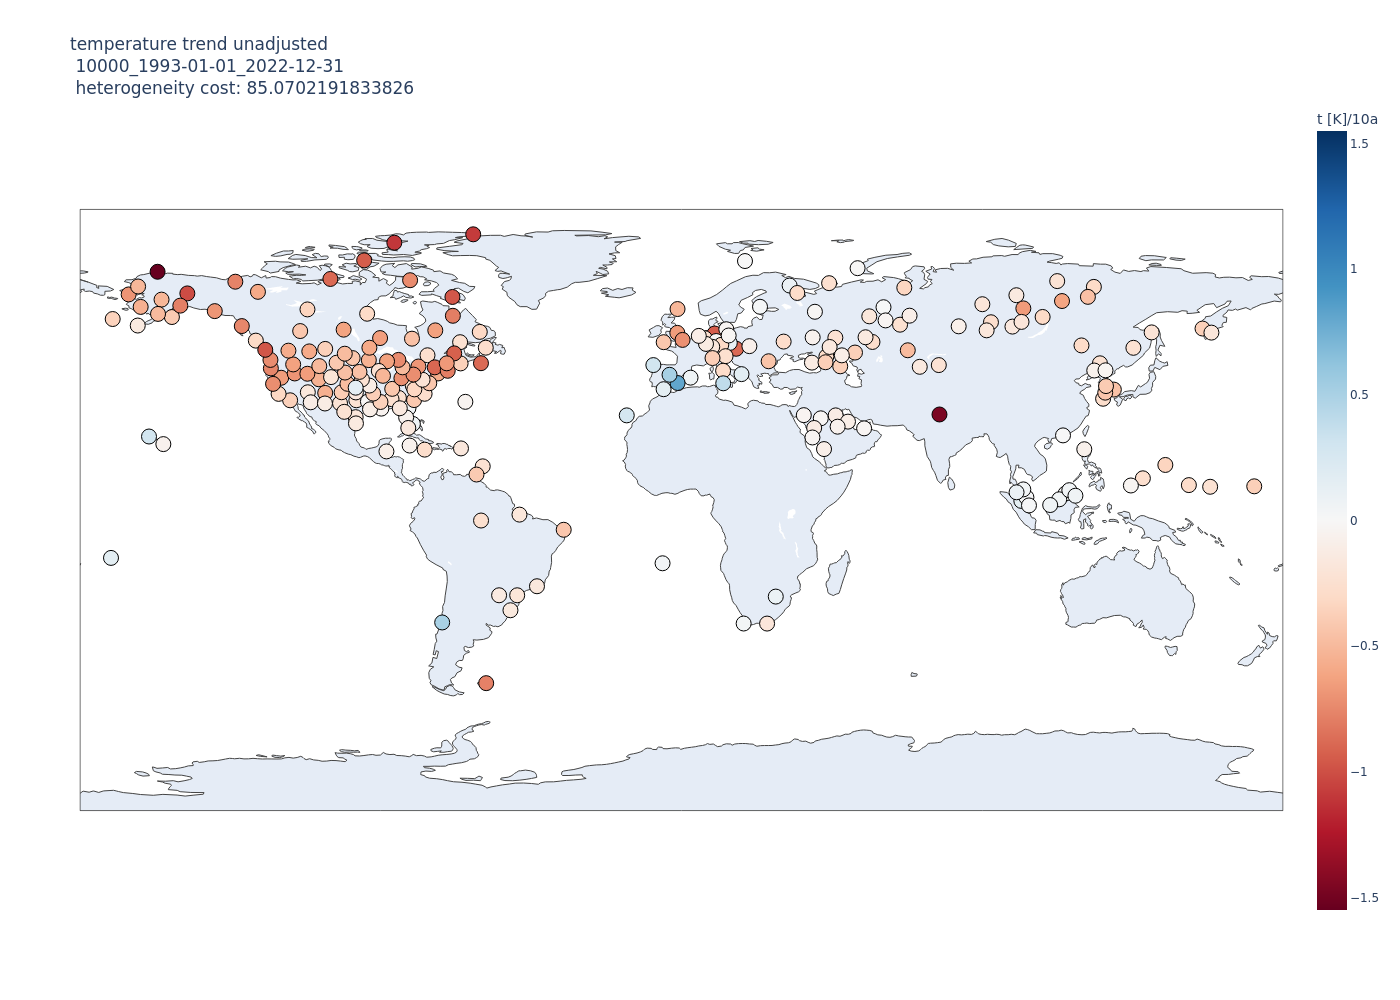

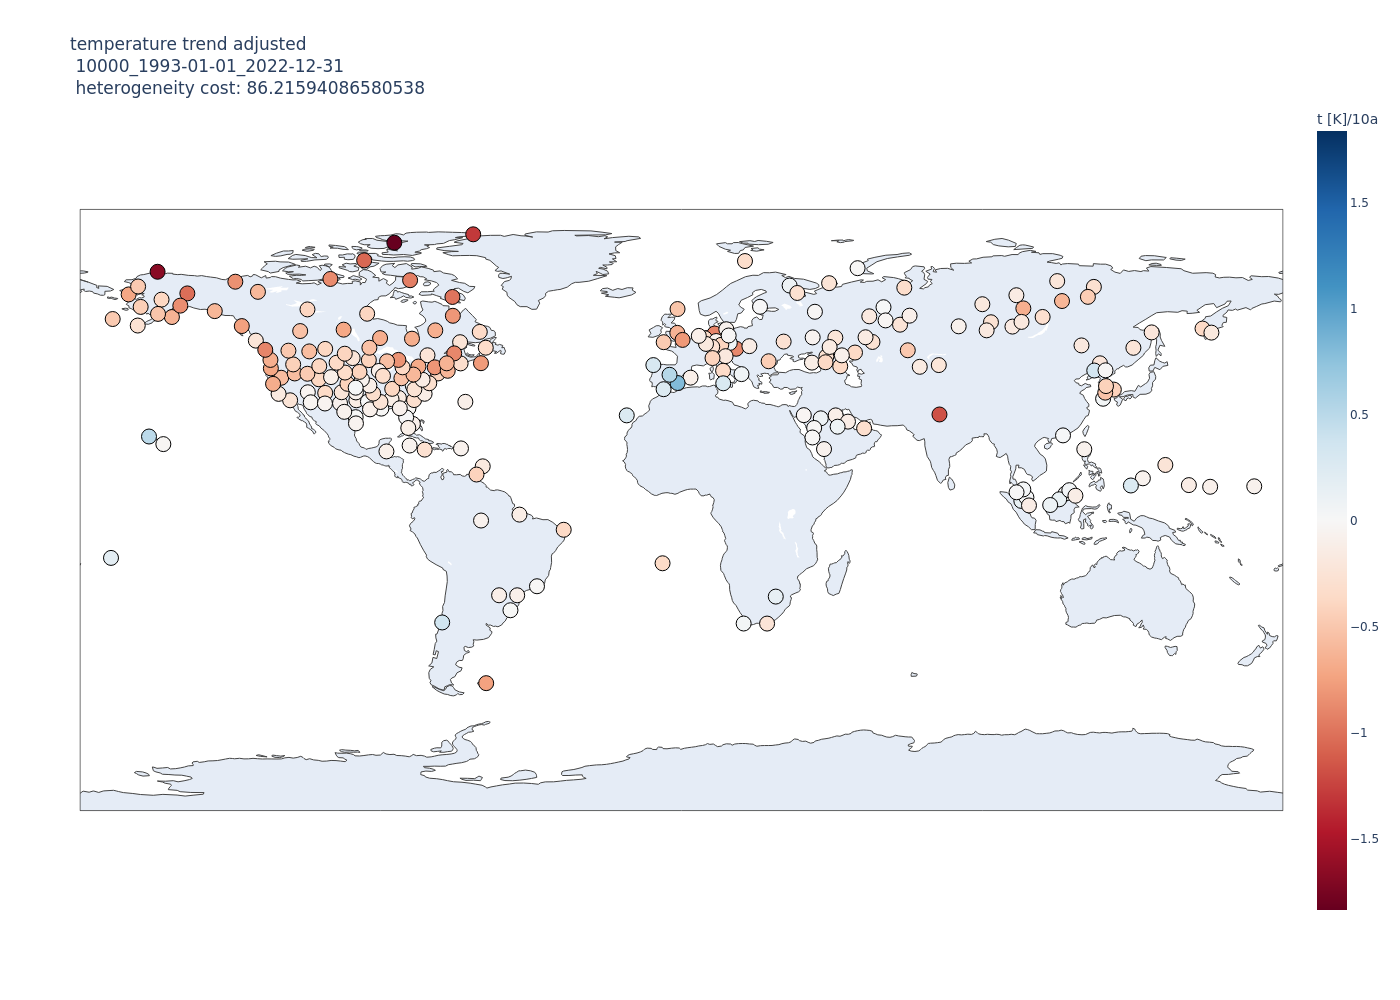

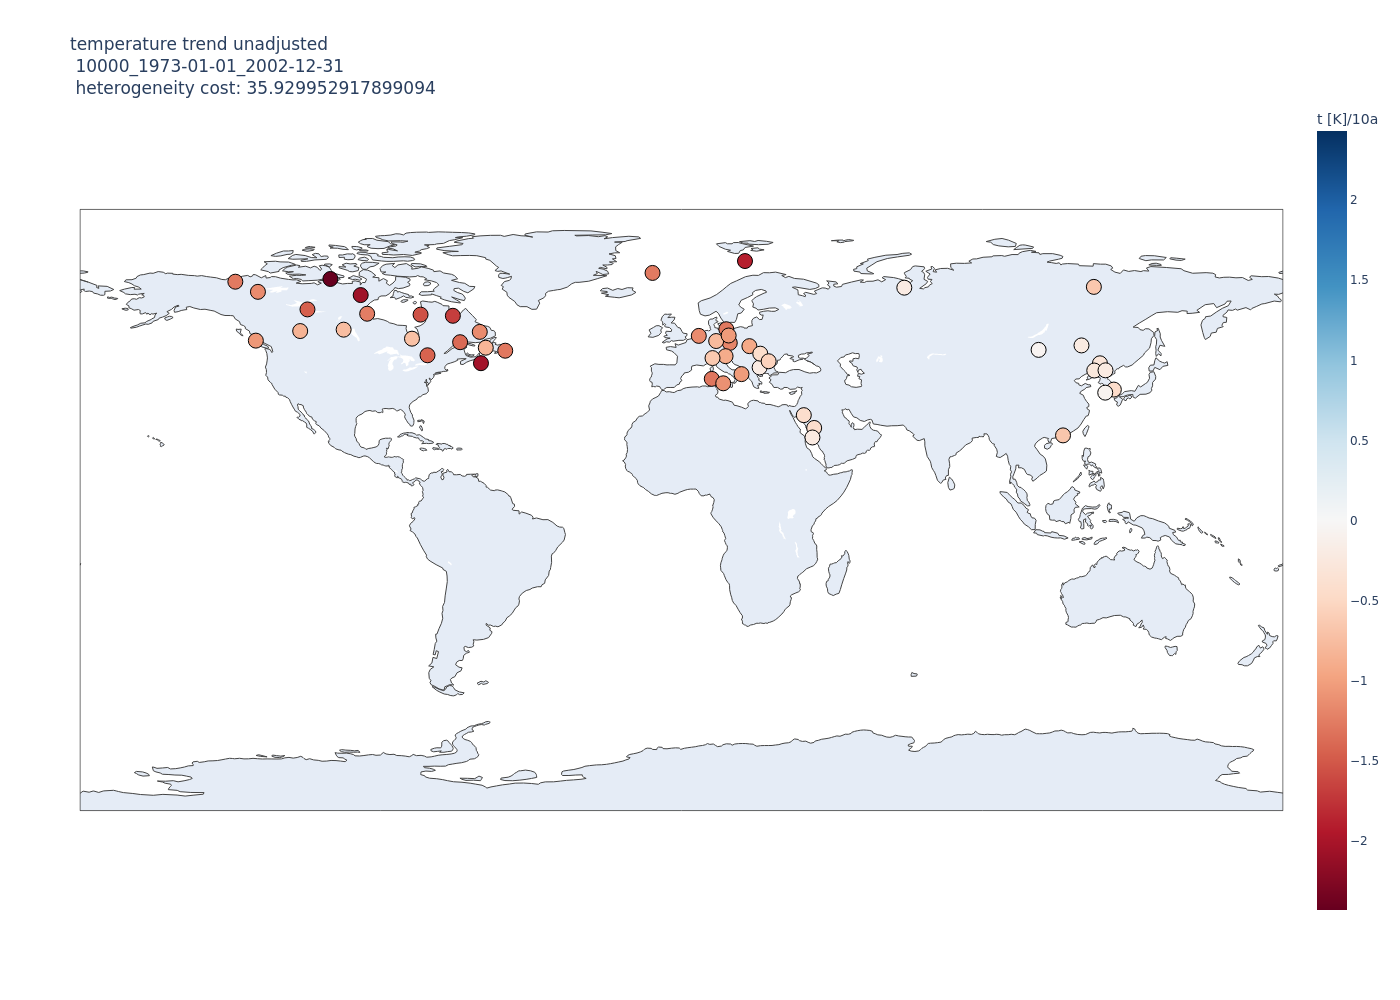

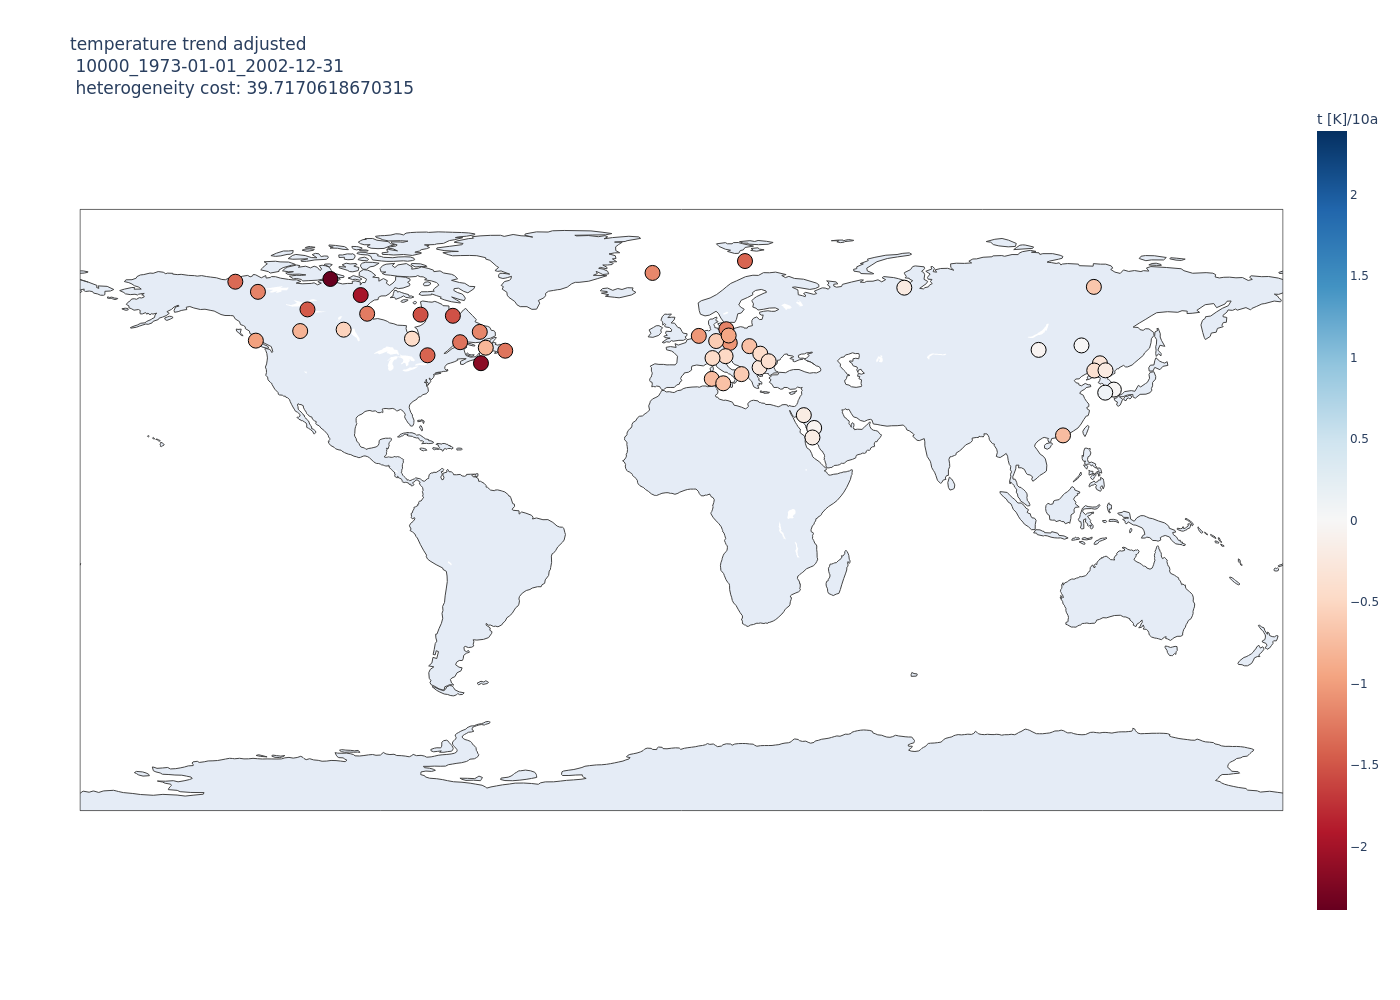

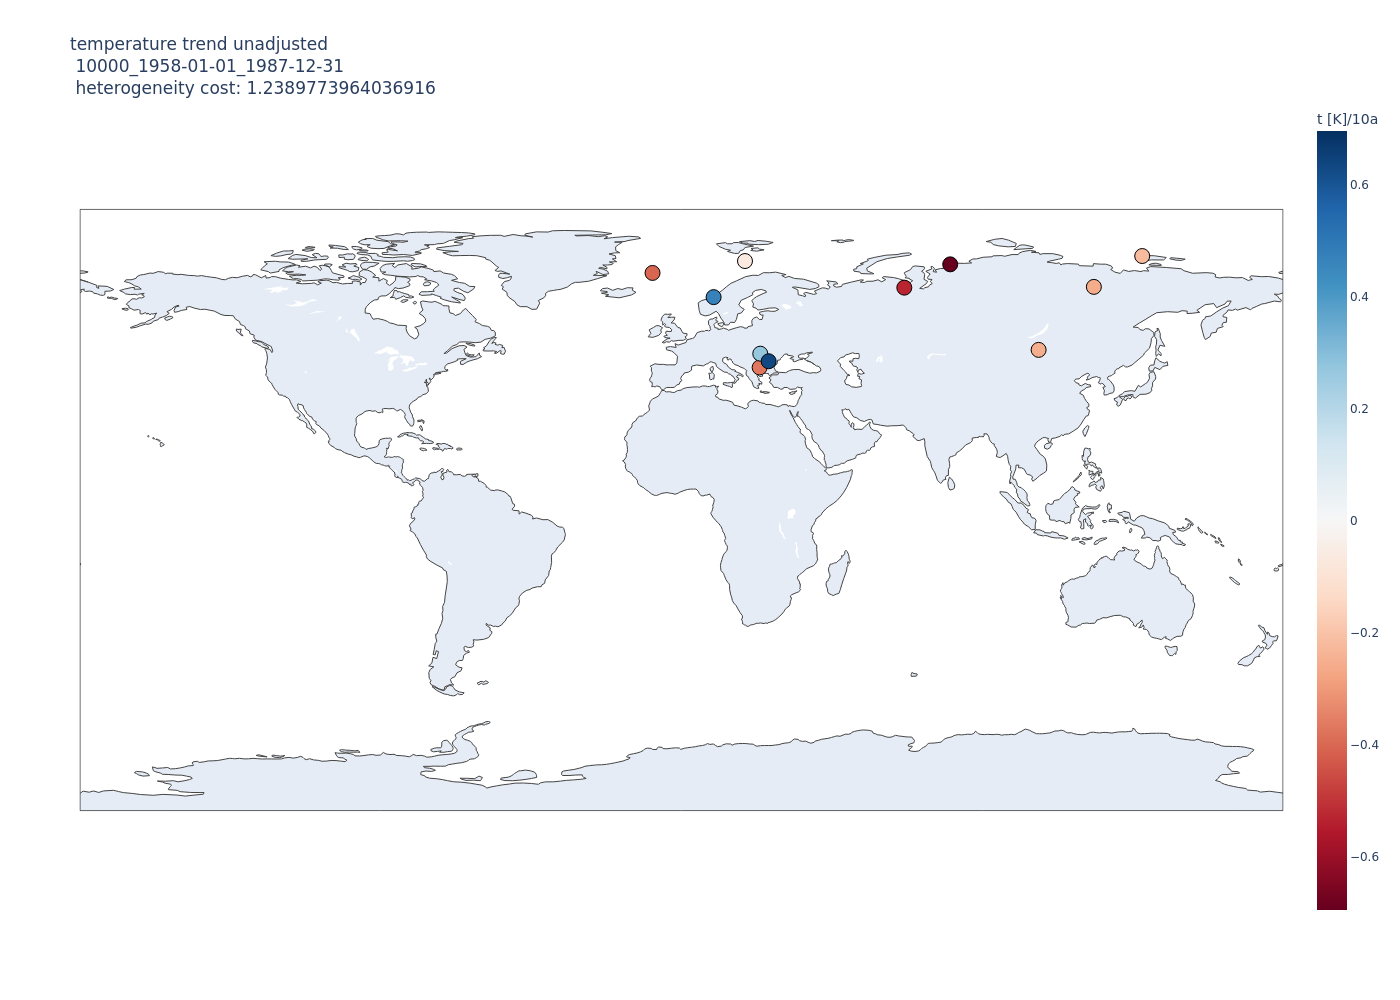

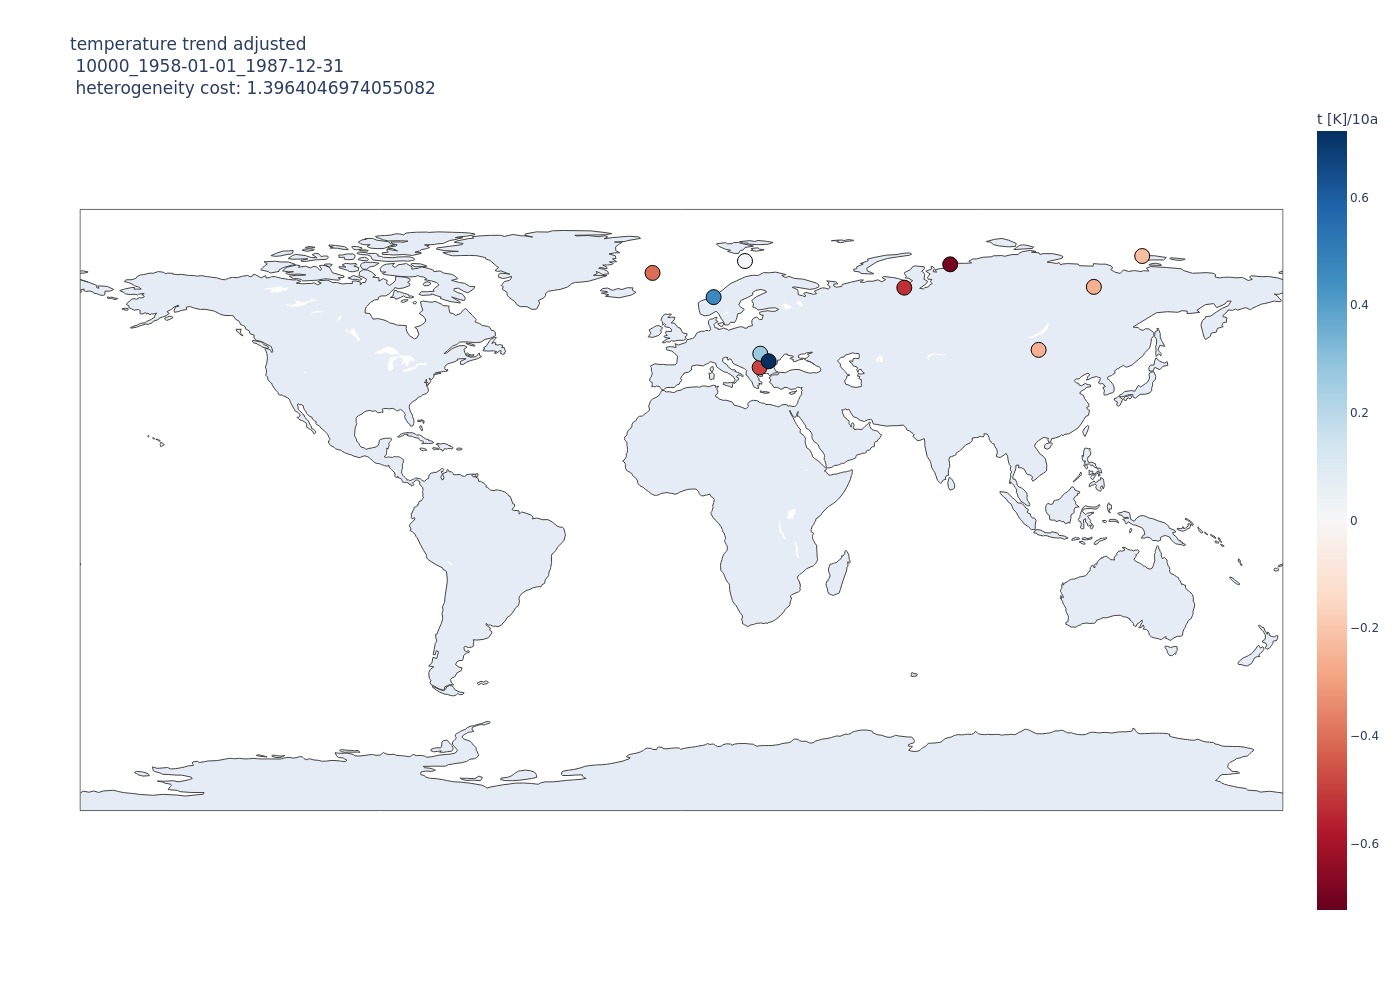

In [16]:
file = 'polyfit_trends_10000_RHARM_2_1958-01-01_1987-12-31_.csv'
var = 'temp'
label = 'test'
c_bar = '[1]'
for i in glob.glob('./polyfit_trends_10000*.csv'):
    show_trend_map(file = i, var = 'temp', label = 'temperature', c_bar = 't [K]/10a')

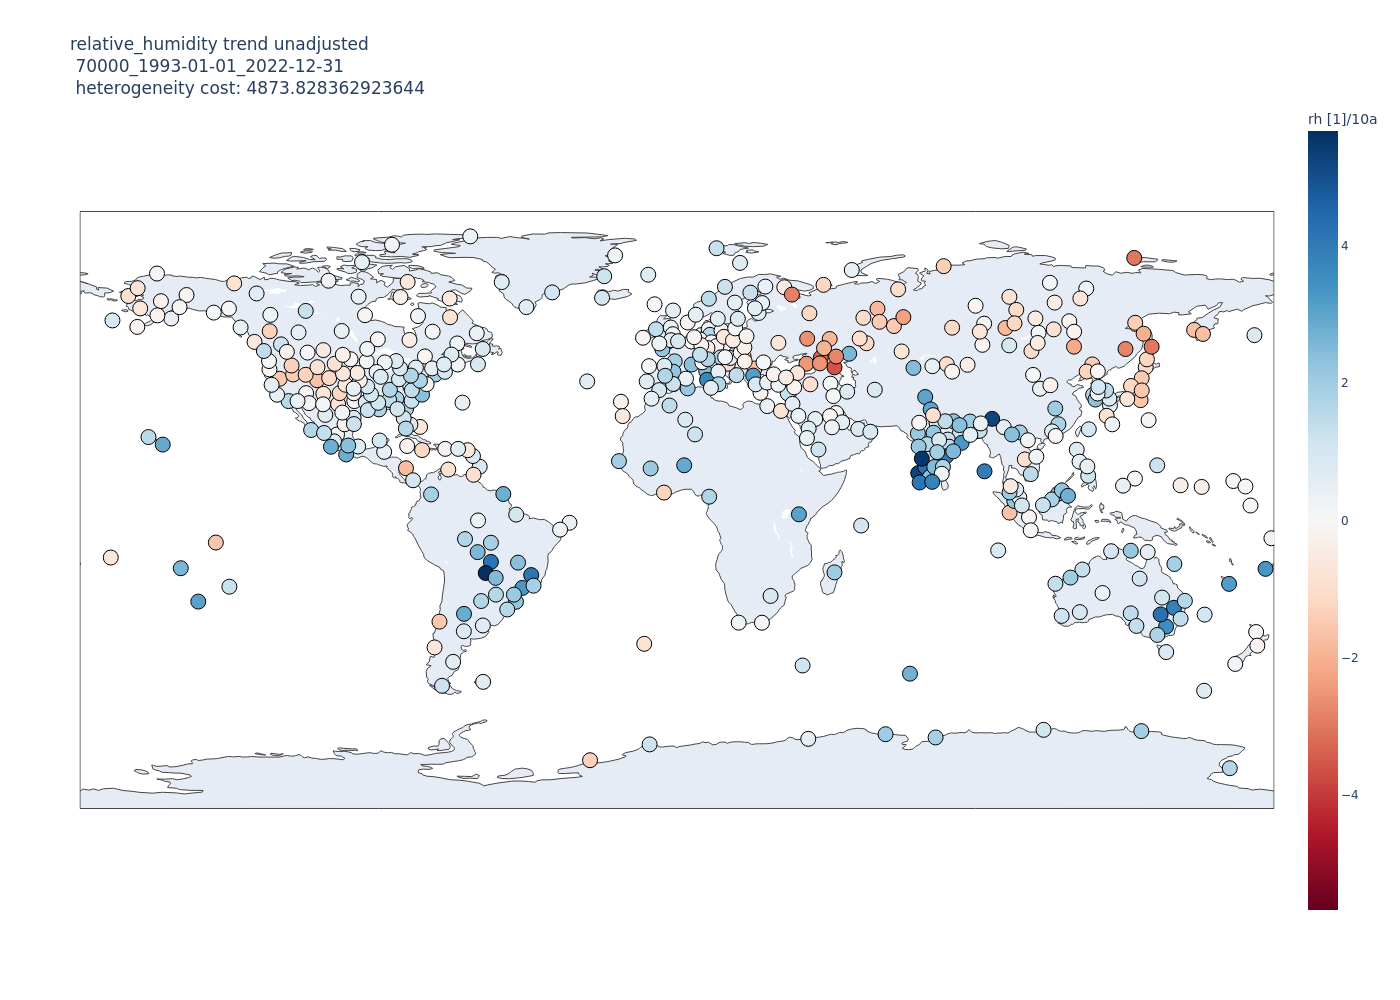

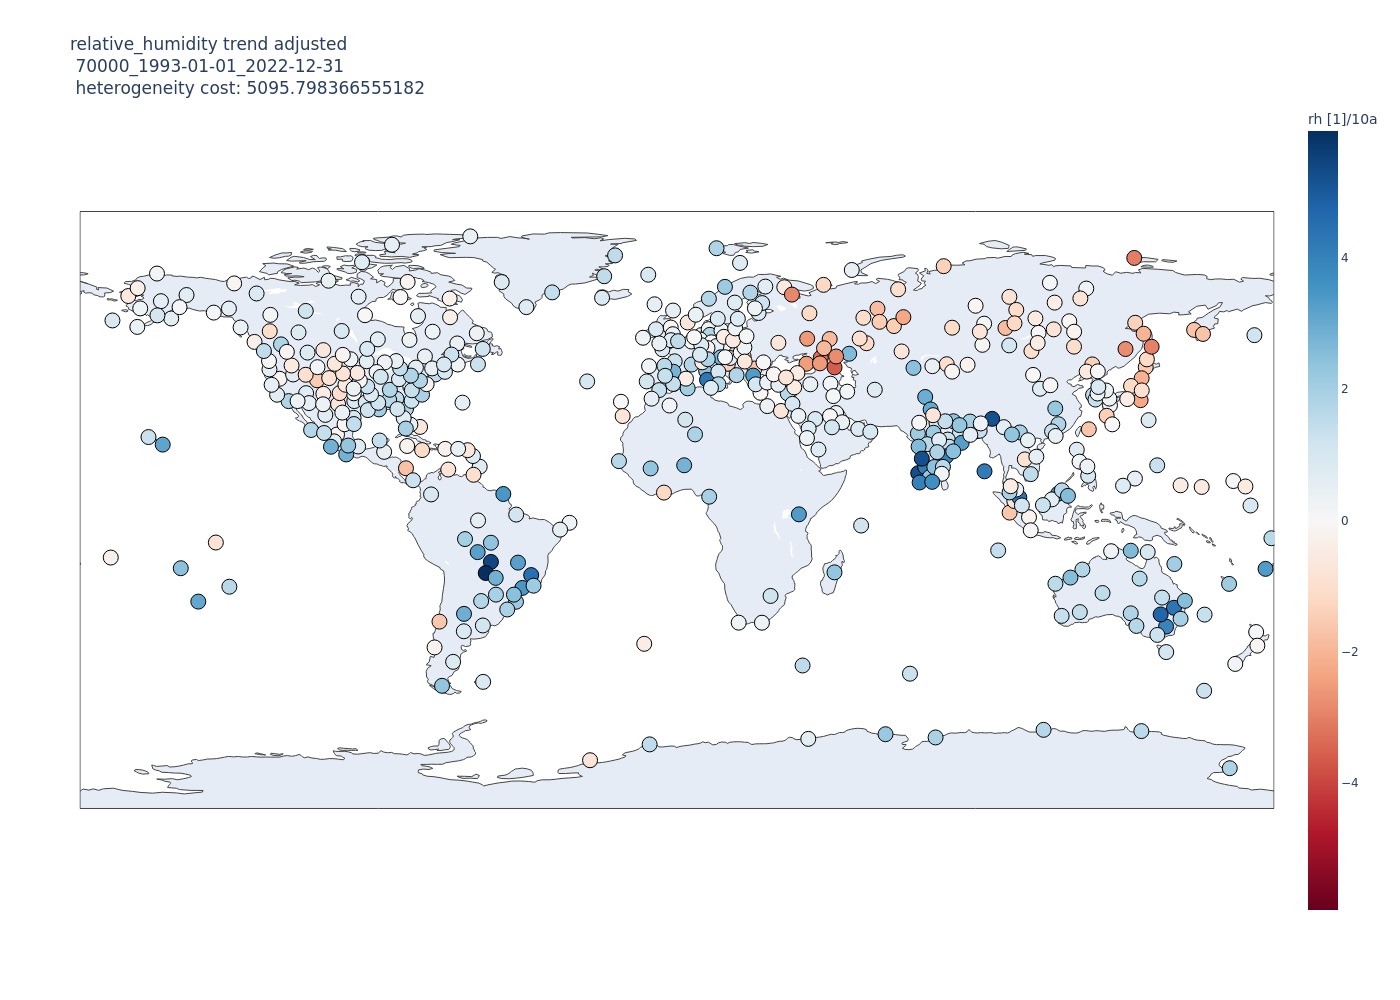

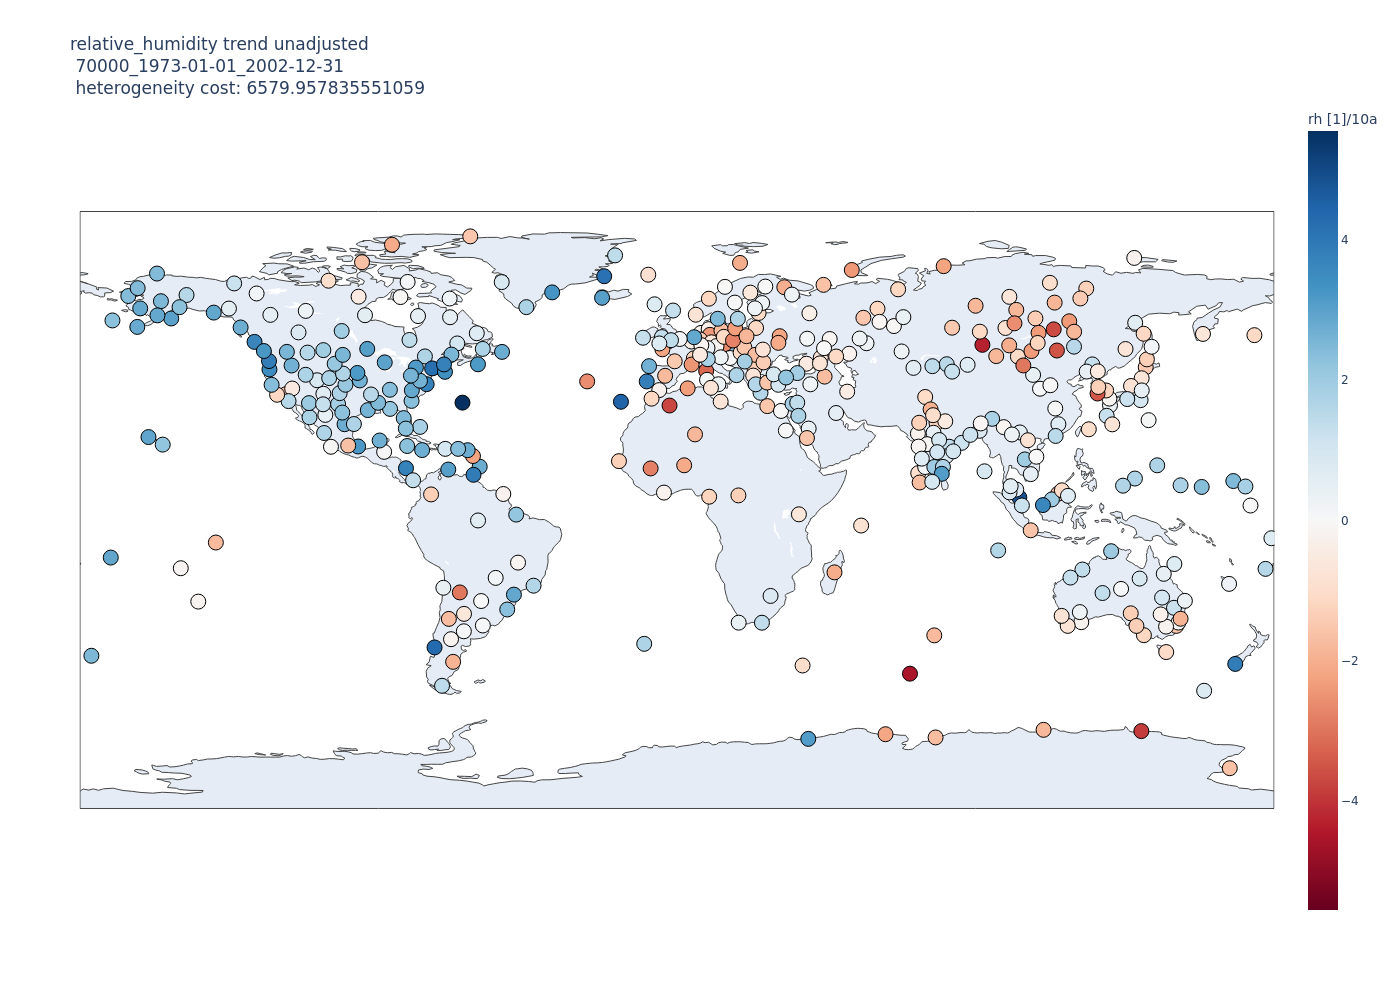

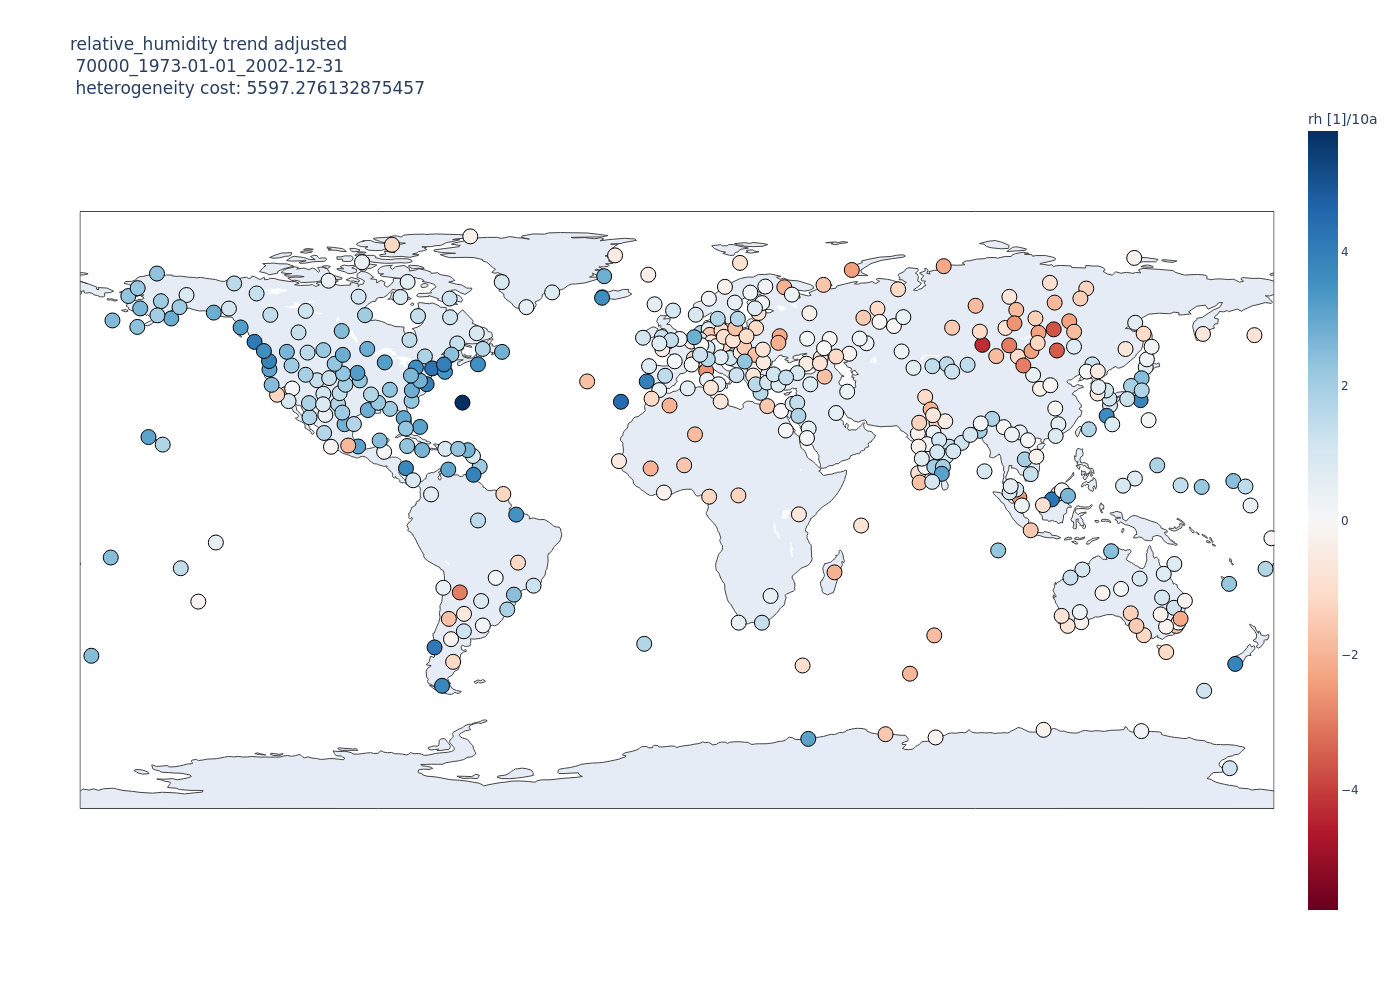

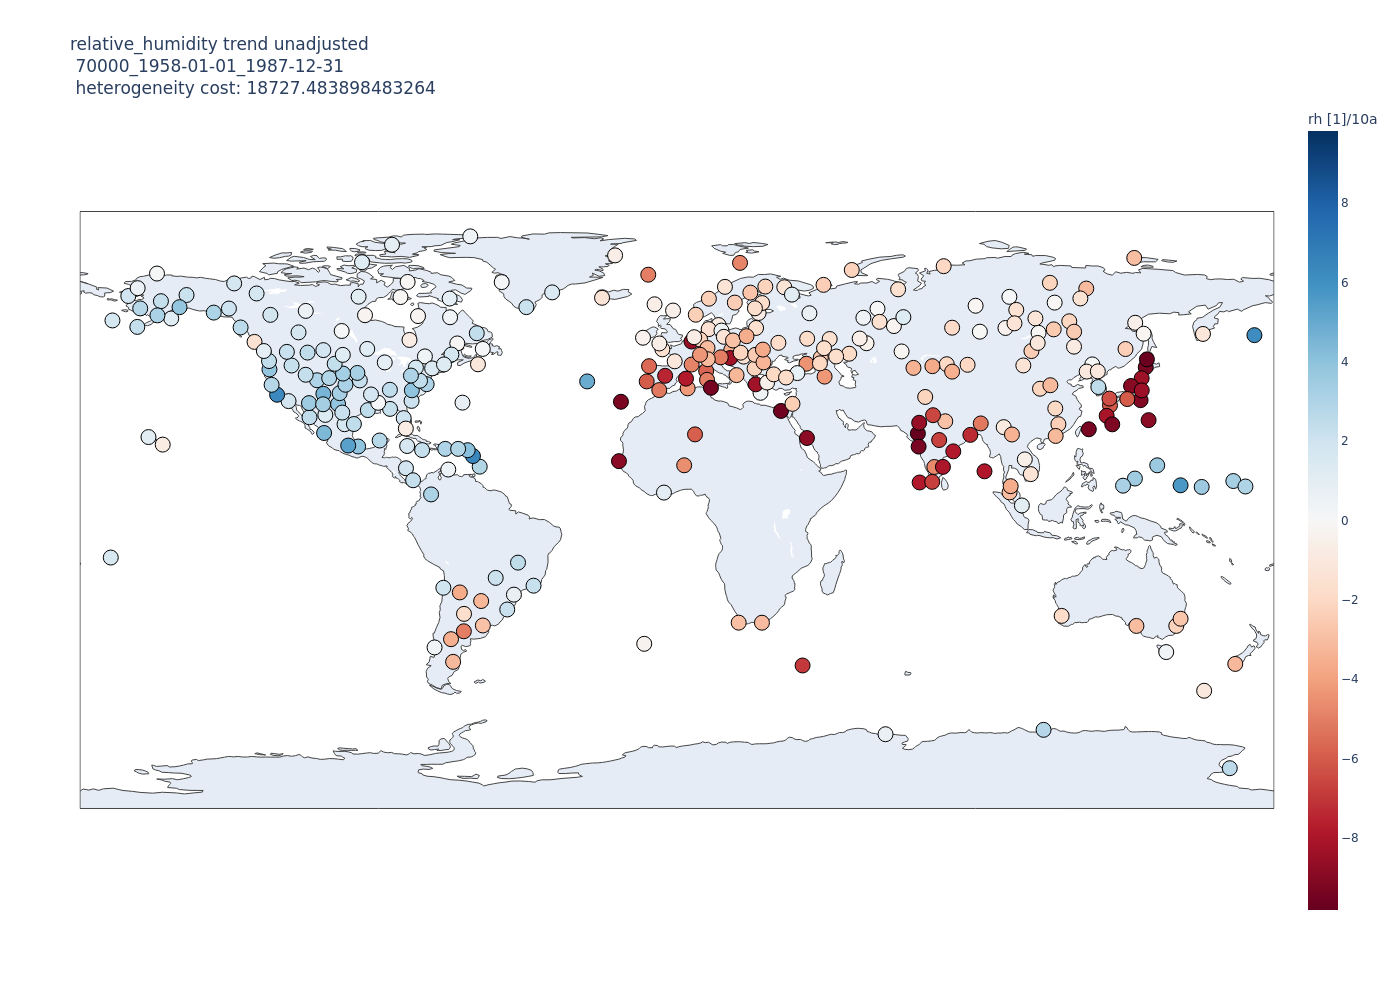

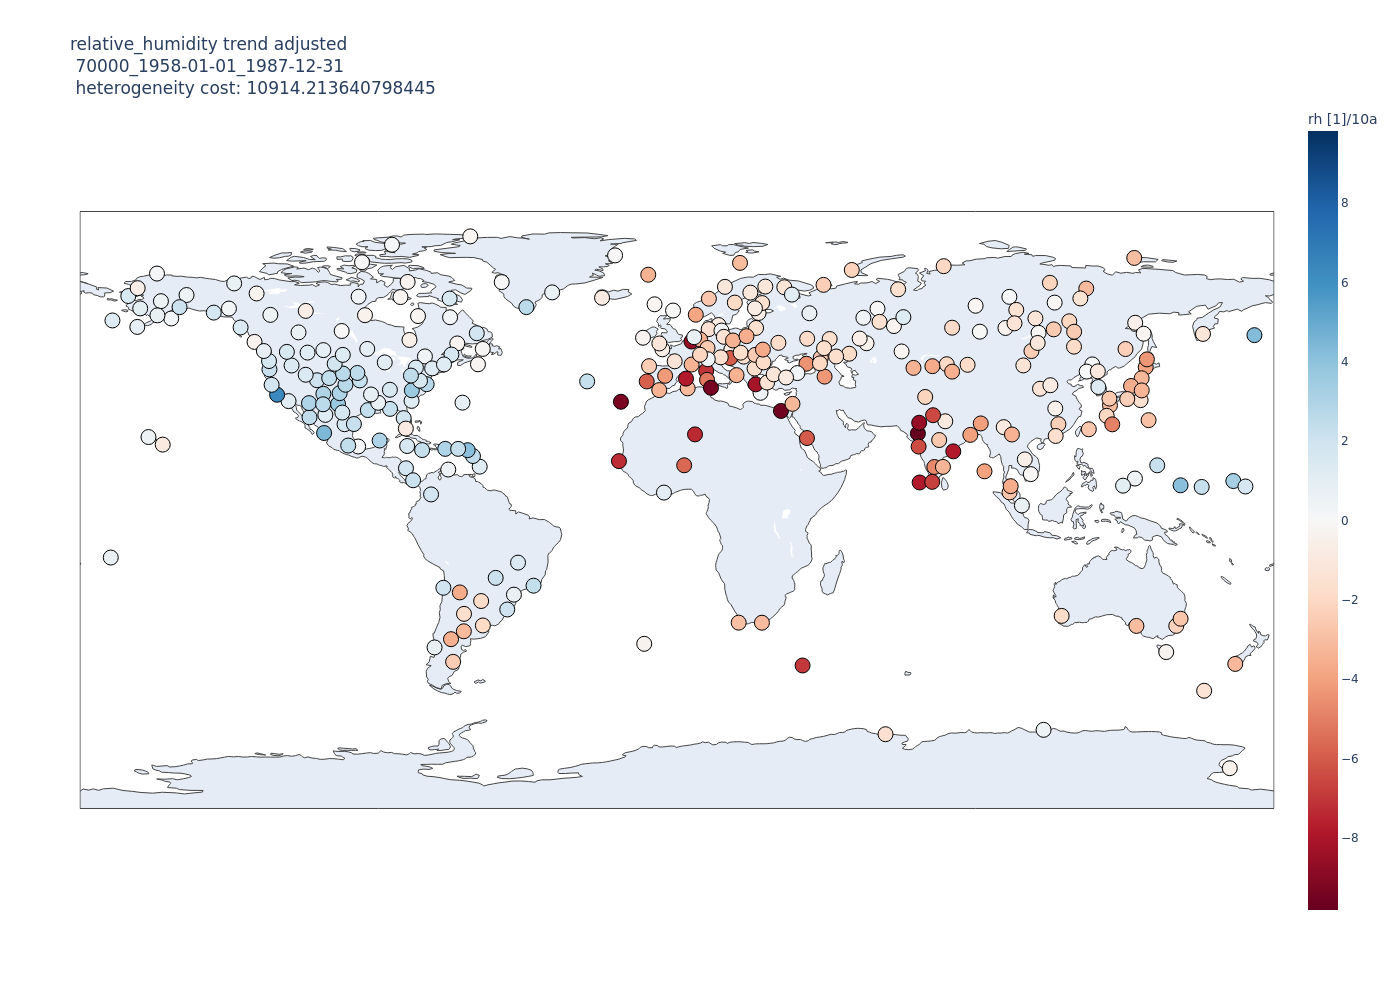

In [17]:
for i in glob.glob('./polyfit_trends_70000*.csv'):
    show_trend_map(file = i, var = 'rh', label = 'relative_humidity', c_bar = 'rh [1]/10a')

In [79]:
# ! pip install h5netcdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.6 MB/s eta 0:00:00


## old files

In [3]:
glob.glob('/users/staff/leo/fastscratch/rise/1.0/exp01/*/rharm_h_??????.nc')

['/users/staff/leo/fastscratch/rise/1.0/exp01/072215/rharm_h_072215.nc',
 '/users/staff/leo/fastscratch/rise/1.0/exp01/011520/rharm_h_011520.nc',
 '/users/staff/leo/fastscratch/rise/1.0/exp01/008023/rharm_h_008023.nc',
 '/users/staff/leo/fastscratch/rise/1.0/exp01/048650/rharm_h_048650.nc',
 '/users/staff/leo/fastscratch/rise/1.0/exp01/028661/rharm_h_028661.nc',
 '/users/staff/leo/fastscratch/rise/1.0/exp01/070273/rharm_h_070273.nc',
 '/users/staff/leo/fastscratch/rise/1.0/exp01/003953/rharm_h_003953.nc',
 '/users/staff/leo/fastscratch/rise/1.0/exp01/044292/rharm_h_044292.nc',
 '/users/staff/leo/fastscratch/rise/1.0/exp01/061024/rharm_h_061024.nc',
 '/users/staff/leo/fastscratch/rise/1.0/exp01/008495/rharm_h_008495.nc',
 '/users/staff/leo/fastscratch/rise/1.0/exp01/091413/rharm_h_091413.nc',
 '/users/staff/leo/fastscratch/rise/1.0/exp01/070414/rharm_h_070414.nc',
 '/users/staff/leo/fastscratch/rise/1.0/exp01/074455/rharm_h_074455.nc',
 '/users/staff/leo/fastscratch/rise/1.0/exp01/06068

## unzip and fix errors from input files -> write to csv

In [124]:
@ray.remote
def unzip_and_fix(rh_i):
    try:
        out_dir = '/users/staff/uvoggenberger/scratch/RHARM_2/'+rh_i.split('/')[-1].split('.bz2')[0]
        with bz2.BZ2File(rh_i) as bz_file:
            line=bz_file.readlines()
            out = [line[0].decode()]
            for i_line in line[1:]:
                x_line = i_line.decode().replace(' ', '')
                x_line = ''.join([x_line.split('"')[0], x_line.split('"')[2]])
                if x_line.count(',') > 100:
                    print('Too many vars: ', rh_i, x_line.count(','), x_line)
                out.append(x_line)
        with open(out_dir,'wb') as file:
            for line in out:
                to_write = line.encode()
                file.write(to_write)
                if to_write[-1:] != b'\n':
                    file.write(b'\n')
        return 0
    
    except:
        return 1, file
# failed


In [125]:
result_ids = []
for file in glob.glob('/users/staff/uvoggenberger/scratch/RHARM_2/*.bz2')[:]:
    result_ids.append(unzip_and_fix.remote(file))

results = ray.get(result_ids)
ray.shutdown()
results

2023-06-29 15:54:08,108	INFO worker.py:1528 -- Started a local Ray instance.


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


## write to netcdf

In [126]:
# @ray.remote
# def write_to_nc(file):
#     try:
#         df = pd.read_csv(file, low_memory=False)
#         renamer = {}
#         for i in df.keys():
#             renamer[i] = i.split(' ')[-1]
#         df = df.rename(columns=renamer)
#         df_sel = df[['rh', 'u', 'v', 'press', 'temp', 'reltime', 'latitude', 'longitude']].copy()
#         df_sel['reltime'] = pd.to_datetime(df_sel['reltime'], format='%Y-%m-%d%H:%M:%S+%f')

#         splevs=[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
#         df_sel = df_sel.copy()[np.isin(df_sel['press'], splevs)]

#         avail = list(df_sel.press.drop_duplicates())
#         for i in splevs:
#             if i in avail:
#                 pass
#             else:
#                 # print(i)
#                 df_sel.loc[len(df_sel.index)] = [np.nan, np.nan, np.nan, i, np.nan, df_sel.reltime.iloc[0], df_sel.latitude.iloc[0], df_sel.longitude.iloc[0]]

#         df_sel =  df_sel.copy()
#         df_sel['hour'] = df_sel['reltime'].dt.hour
#         hour_binary = np.array([0]*len(df_sel['hour']))
#         hour_binary[np.logical_and(df_sel['hour'] > 6 , df_sel['hour'] <= 18)] = 1
#         df_sel['hour'] = hour_binary

#         df_sel['station'] = [0]*len(df_sel)

#         df_sel['pressure'] = df_sel['press']
#         df_sel['time'] = df_sel['reltime']

#         df_sel = df_sel.rename(columns={'reltime': 'datum', 'temp':'ta', 'latitude':'lat', 'longitude':'lon'})

#         df_mi = df_sel.set_index(['station', 'time', 'pressure', 'hour'])

#         df_mi = df_mi[~df_mi.index.duplicated(keep='first')]

#         da = df_mi.to_xarray()

#         compression =  {}
#         for vars in da.keys():
#             compression[vars] = {"compression": "gzip", "compression_opts": 5}

#         da.to_netcdf('/users/staff/uvoggenberger/scratch/RHARM_2/'+file.split('/')[-1].split('.')[0]+'.nc', engine='h5netcdf', encoding=compression)

#         return 0
#     except:
#         return 1, file


In [6]:
@ray.remote
def write_to_nc(file):
    try:
        df = pd.read_csv(file, low_memory=False)
        renamer = {}
        for i in df.keys():
            renamer[i] = i.split(' ')[-1]
        df = df.rename(columns=renamer)
        # df.to_csv('/'.join(file.split('/')[:-1]) +'/cleaned_'+ file.split('/')[-1])
        df_sel = df[['rh', 'u', 'v', 'press', 'temp','rh_h', 'u_h', 'v_h', 'temp_h', 'reltime', 'latitude', 'longitude']].copy()
        df_sel['reltime'] = pd.to_datetime(df_sel['reltime'], format='%Y-%m-%d%H:%M:%S+%f')

        splevs=[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
        df_sel = df_sel.copy()[np.isin(df_sel['press'], splevs)]

        avail = list(df_sel.press.drop_duplicates())
        for i in splevs:
            if i in avail:
                pass
            else:
                # print(i)
                # df_sel.loc[len(df_sel.index)] = [np.nan, np.nan, np.nan, i, np.nan, df_sel.reltime.iloc[0], df_sel.latitude.iloc[0], df_sel.longitude.iloc[0]]
                df_add = pd.DataFrame({"rh":np.nan, "u": np.nan, "v": np.nan, "press": i, "temp":np.nan,"rh_h":np.nan, "u_h": np.nan, "v_h": np.nan, "temp_h":np.nan, "reltime": df_sel.reltime.iloc[0], "latitude": df_sel.latitude.iloc[0], "longitude": df_sel.longitude.iloc[0]},
                   index=["1"])
                df_sel = pd.concat([df_sel, df_add], ignore_index=True)

        df_sel =  df_sel.copy()
        df_sel['hour'] = df_sel['reltime'].dt.hour
        hour_binary = np.array([0]*len(df_sel['hour']))
        hour_binary[np.logical_and(df_sel['hour'] > 6 , df_sel['hour'] <= 18)] = 1
        df_sel['hour'] = hour_binary


        df_sel['station'] = [0]*len(df_sel)

        df_sel['pressure'] = df_sel['press']

        sec_dates = []
        for i in df_sel.reltime:
            if i.hour > 18:
                sec_dates.append(int((i.ceil('1d') - pd.Timestamp('1900-01-01 00:00:00')).total_seconds()))
            else:
                sec_dates.append(int((i.floor('1d') - pd.Timestamp('1900-01-01 00:00:00')).total_seconds()))
        df_sel['reltime'] = sec_dates
        df_sel['time'] = df_sel['reltime']

        df_sel = df_sel.rename(columns={'reltime': 'datum', 'temp':'ta', 'temp_h':'ta_h', 'latitude':'lat', 'longitude':'lon'})

        df_mi = df_sel.set_index(['time', 'pressure', 'hour'])

        df_mi = df_mi[~df_mi.index.duplicated(keep='first')]

        da = df_mi.to_xarray()

        # compression =  {}
        # for vars in da.keys():
        #     compression[vars] = {"compression": "gzip", "compression_opts": 5}

        # da.to_netcdf('/users/staff/uvoggenberger/scratch/RHARM_2/'+file.split('/')[-1].split('.')[0]+'.nc', engine='h5netcdf', encoding=compression)

        fn = '/users/staff/uvoggenberger/scratch/RHARM_2/'+file.split('/')[-1].split('.')[0].split('_')[-1]+'.nc'
        statid = file.split('/')[-1].split('.csv')[0]

        with nc.Dataset(fn, 'w', format='NETCDF4') as ds:

            # Dimensions:
            station = ds.createDimension('station', 1)
            # numdat = ds.createDimension('numdat', 1)
            time = ds.createDimension('time', len(df_sel.datum.drop_duplicates()))
            pressure = ds.createDimension('pressure', 16)
            hour = ds.createDimension('hour', 2)

            # Variables:
            lat = ds.createVariable('lat', 'f4', ('station',))
            lon = ds.createVariable('lon', 'f4', ('station',))
            press = ds.createVariable('press', 'f4', ('pressure',))
            ta = ds.createVariable('ta', 'f4', ('hour', 'pressure', 'time'))
            rh = ds.createVariable('rh', 'f4', ('hour', 'pressure', 'time'))
            v = ds.createVariable('v', 'f4', ('hour', 'pressure', 'time'))
            u = ds.createVariable('u', 'f4', ('hour', 'pressure', 'time'))
            ta_h = ds.createVariable('ta_h', 'f4', ('hour', 'pressure', 'time'))
            rh_h = ds.createVariable('rh_h', 'f4', ('hour', 'pressure', 'time'))
            v_h = ds.createVariable('v_h', 'f4', ('hour', 'pressure', 'time'))
            u_h = ds.createVariable('u_h', 'f4', ('hour', 'pressure', 'time'))
            datum = ds.createVariable('datum', 'i8', ('hour', 'time',))

            # Attributes:

            lat.long_name = "station latitude"
            lat.units = "degrees_north"
            lat.axis = "Y"
            lat.valid_range = [-90.,90.]
            lat.missing_value = -999.

            lon.long_name = "station longitude"
            lon.units = "degrees_east"
            lon.axis = "X"
            lon.valid_range = [-180., 180.]
            lon.missing_value = -999.

            press.long_name = "pressure"
            press.units = "Pa"
            press.axis = "Z"
            press.valid_range = [1000.,100000.]
            press.missing_value = -999.

            datum.long_name = "datum"
            datum.units = "seconds since 1900-01-01 0:0:0"
            datum.axis = "T"
            datum.calendar = "gregorian"
            datum.missing_value = -9223372036854775808

            ta.long_name = "temperature"
            ta.units = "K"
            ta.missing_value = -999.
            ta.valid_range = [0., 400.]
            ta.cell_methods = "time"

            rh.long_name = "relative_humidity"
            rh.units = "1"
            rh.missing_value = -999.
            rh.valid_range = [0., 1.]
            rh.cell_methods = "time"

            u.long_name = "eastward_wind"
            u.units = "m/s"
            u.missing_value = -999.
            u.valid_range = [0., 400.]
            u.cell_methods = "time"

            v.long_name = "northward_wind"
            v.units = "m/s"
            v.missing_value = -999.
            v.valid_range = [0., 400.]
            v.cell_methods = "time"

            ta_h.long_name = "homogenized_temperature"
            ta_h.units = "K"
            ta_h.missing_value = -999.
            ta_h.valid_range = [0., 400.]
            ta_h.cell_methods = "time"

            rh_h.long_name = "homogenized_relative_humidity"
            rh_h.units = "1"
            rh_h.missing_value = -999.
            rh_h.valid_range = [0., 1.]
            rh_h.cell_methods = "time"

            u_h.long_name = "homogenized_eastward_wind"
            u_h.units = "m/s"
            u_h.missing_value = -999.
            u_h.valid_range = [0., 400.]
            u_h.cell_methods = "time"

            v_h.long_name = "homogenized_northward_wind"
            v_h.units = "m/s"
            v_h.missing_value = -999.
            v_h.valid_range = [0., 400.]
            v_h.cell_methods = "time"

            # Global Attributes:
            ds.Conventions = "CF-1.1" ;
            ds.title = "" ;
            ds.institution = "University of Vienna" ;
            ds.history = "03/07/23" ;
            ds.source = "RHARM" ;
            ds.references = "www.univie.ac.at/theoret-met/research/raobcore" ;
            ds.Stationname = str(statid) ;


            # populating Variables:
            # print('c h')
            datum_helper = np.transpose(np.array(da.datum.mean(dim=['hour','pressure'], skipna=True)))
            # print('d h')
            datum[:,:] =  [datum_helper.astype(int), datum_helper.astype(int)]
            # print('w h')
            pressure = splevs

            ta[:,:,:] =  np.transpose(np.array(da.ta[:,:,:]))
            rh[:,:,:] =  np.transpose(np.array(da.rh[:,:,:]))
            u[:,:,:] =  np.transpose(np.array(da.u[:,:,:]))
            v[:,:,:] =  np.transpose(np.array(da.v[:,:,:]))
            ta_h[:,:,:] =  np.transpose(np.array(da.ta_h[:,:,:]))
            rh_h[:,:,:] =  np.transpose(np.array(da.rh_h[:,:,:]))
            u_h[:,:,:] =  np.transpose(np.array(da.u_h[:,:,:]))
            v_h[:,:,:] =  np.transpose(np.array(da.v_h[:,:,:]))
            press[:] = splevs

            lat[:] = df_sel.lat.iloc[0]
            lon[:] = df_sel.lon.iloc[0]

        return 0
    except:
        return 1, file



In [7]:
result_ids = []
for file in glob.glob('/users/staff/uvoggenberger/scratch/RHARM_2/cleaned*.csv')[:]:
    result_ids.append(write_to_nc.remote(file))
    # print(write_to_nc(file))

results = ray.get(result_ids)
ray.shutdown()
results

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [38]:
len(results)

978

In [17]:
rs = np.array(results)

/tmp/ipykernel_2417781/3544175399.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rs = np.array(results)


In [18]:
rs[rs != 0]

array([(1, '/users/staff/uvoggenberger/scratch/RHARM_2/cleaned_AGM00060686.csv'),
       (1, '/users/staff/uvoggenberger/scratch/RHARM_2/cleaned_AFM00040911.csv'),
       (1, '/users/staff/uvoggenberger/scratch/RHARM_2/cleaned_BCM00068240.csv'),
       (1, '/users/staff/uvoggenberger/scratch/RHARM_2/cleaned_cleaned_AGM00060686.csv'),
       (1, '/users/staff/uvoggenberger/scratch/RHARM_2/cleaned_cleaned_AFM00040911.csv')],
      dtype=object)

In [13]:
file = glob.glob('/users/staff/uvoggenberger/scratch/RHARM_2/*.csv')[0]


'/users/staff/uvoggenberger/scratch/RHARM_2/cleaned_AFM00040948.csv'

In [37]:
file = '/users/staff/uvoggenberger/scratch/RHARM_2/AFM00040948.csv'
renamer = {}
for i in df.keys():
    renamer[i] = i.split(' ')[-1]
df = df.rename(columns=renamer)
df_sel = df[['rh', 'u', 'v', 'press', 'temp', 'reltime', 'latitude', 'longitude']].copy()
df_sel['reltime'] = pd.to_datetime(df_sel['reltime'], format='%Y-%m-%d%H:%M:%S+%f')


splevs=[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
df_sel = df_sel.copy()[np.isin(df_sel['press'], splevs)]

avail = list(df_sel.press.drop_duplicates())
print(len(df_sel), len(df_sel.press.drop_duplicates()))        

for i in splevs:
    if i in avail:
        pass
    else:
        df_add = pd.DataFrame({"rh":np.nan, "u": np.nan, "v": np.nan, "press": i, "temp":np.nan, "reltime": df_sel.reltime.iloc[0], "latitude": df_sel.latitude.iloc[0], "longitude": df_sel.longitude.iloc[0]},
                   index=["1"])
        df_sel = pd.concat([df_sel, df_add], ignore_index=True)
        # df_sel.loc[len(df_sel.index)+1] = [np.nan, np.nan, np.nan, i, np.nan, df_sel.reltime.iloc[0], df_sel.latitude.iloc[0], df_sel.longitude.iloc[0]]
        # display(df_sel[df_sel.press == i])
        print(len(df_sel.index),len(df_sel.press.drop_duplicates()))        


print(len(df_sel.press.drop_duplicates()))  
print(df_sel.press.drop_duplicates())     
        
df_sel =  df_sel.copy()
df_sel['hour'] = df_sel['reltime'].dt.hour
hour_binary = np.array([0]*len(df_sel['hour']))
hour_binary[np.logical_and(df_sel['hour'] > 6 , df_sel['hour'] <= 18)] = 1
df_sel['hour'] = hour_binary


df_sel['station'] = [0]*len(df_sel)

df_sel['pressure'] = df_sel['press']


sec_dates = []
for i in df_sel.reltime:
    if i.hour > 18:
        sec_dates.append(int((i.ceil('1d') - pd.Timestamp('1900-01-01 00:00:00')).total_seconds()))
    else:
        sec_dates.append(int((i.floor('1d') - pd.Timestamp('1900-01-01 00:00:00')).total_seconds()))
df_sel['reltime'] = sec_dates
df_sel['time'] = df_sel['reltime']

df_sel = df_sel.rename(columns={'reltime': 'datum', 'temp':'ta', 'latitude':'lat', 'longitude':'lon'})

df_mi = df_sel.set_index(['time', 'pressure', 'hour'])

df_mi = df_mi[~df_mi.index.duplicated(keep='first')]

da = df_mi.to_xarray()

# compression =  {}
# for vars in da.keys():
#     compression[vars] = {"compression": "gzip", "compression_opts": 5}

# da.to_netcdf('/users/staff/uvoggenberger/scratch/RHARM_2/'+file.split('/')[-1].split('.')[0]+'.nc', engine='h5netcdf', encoding=compression)

fn = '/users/staff/uvoggenberger/scratch/RHARM_2/'+file.split('/')[-1].split('.')[0]+'.nc'
statid = file.split('/')[-1].split('.csv')[0]

with nc.Dataset(fn, 'w', format='NETCDF4') as ds:

    # Dimensions:
    station = ds.createDimension('station', 1)
    # numdat = ds.createDimension('numdat', 1)
    time = ds.createDimension('time', len(df_sel.datum.drop_duplicates()))
    pressure = ds.createDimension('pressure', 16)
    hour = ds.createDimension('hour', 2)

    # Variables:
    lat = ds.createVariable('lat', 'f4', ('station',))
    lon = ds.createVariable('lon', 'f4', ('station',))
    press = ds.createVariable('press', 'f4', ('pressure',))
    ta = ds.createVariable('ta', 'f4', ('hour', 'pressure', 'time'))
    rh = ds.createVariable('rh', 'f4', ('hour', 'pressure', 'time'))
    v = ds.createVariable('v', 'f4', ('hour', 'pressure', 'time'))
    u = ds.createVariable('u', 'f4', ('hour', 'pressure', 'time'))
    datum = ds.createVariable('datum', 'f4', ('hour', 'time',))

    # Attributes:

    lat.long_name = "station latitude"
    lat.units = "degrees_north"
    lat.axis = "Y"
    lat.valid_range = [-90.,90.]
    lat.missing_value = -999.

    lon.long_name = "station longitude"
    lon.units = "degrees_east"
    lon.axis = "X"
    lon.valid_range = [-180., 180.]
    lon.missing_value = -999.

    press.long_name = "pressure"
    press.units = ""
    press.axis = "Z"
    press.valid_range = [1000.,100000.]
    press.missing_value = -999.

    datum.long_name = "datum"
    datum.units = "days since 1900-01-01 0:0:0"
    datum.axis = "T"
    datum.calendar = "gregorian"
    datum.missing_value = -999.

    ta.long_name = "temperature"
    ta.units = "K"
    ta.missing_value = -999.
    ta.valid_range = [0., 400.]
    ta.cell_methods = "time"

    rh.long_name = "relative_humidity"
    ta.units = "K"
    ta.missing_value = -999.
    ta.valid_range = [0., 400.]
    ta.cell_methods = "time"

    u.long_name = "eastward_wind"
    u.units = "m/s"
    u.missing_value = -999.
    u.valid_range = [0., 400.]
    u.cell_methods = "time"

    v.long_name = "northward_wind"
    v.units = "m/s"
    v.missing_value = -999.
    v.valid_range = [0., 400.]
    v.cell_methods = "time"
    
    ta.long_name = "homogenized_temperature"
    ta.units = "K"
    ta.missing_value = -999.
    ta.valid_range = [0., 400.]
    ta.cell_methods = "time"

    rh.long_name = "homogenized_relative_humidity"
    rh.units = "K"
    rh.missing_value = -999.
    rh.valid_range = [0., 400.]
    rh.cell_methods = "time"

    u.long_name = "homogenized_eastward_wind"
    u.units = "m/s"
    u.missing_value = -999.
    u.valid_range = [0., 400.]
    u.cell_methods = "time"

    v.long_name = "homogenized_northward_wind"
    v.units = "m/s"
    v.missing_value = -999.
    v.valid_range = [0., 400.]
    v.cell_methods = "time"

    # Global Attributes:
    ds.Conventions = "CF-1.1" ;
    ds.title = "" ;
    ds.institution = "University of Vienna" ;
    ds.history = "03/07/23" ;
    ds.source = "RHARM" ;
    ds.references = "www.univie.ac.at/theoret-met/research/raobcore" ;
    ds.Stationname = str(statid) ;


    # populating Variables:

    datum[:,:] =  np.transpose(np.array(da.datum.mean(dim='pressure', skipna=True)))
    pressure = splevs

    ta[:,:,:] =  np.transpose(np.array(da.ta[:,:,:]))
    rh[:,:,:] =  np.transpose(np.array(da.rh[:,:,:]))
    u[:,:,:] =  np.transpose(np.array(da.u[:,:,:]))
    v[:,:,:] =  np.transpose(np.array(da.v[:,:,:]))
    press[:] = splevs

    lat[:] = df_sel.lat.iloc[0]
    lon[:] = df_sel.lon.iloc[0]

157528 13
157529 14
157530 15
157531 16
16
0          50000
1          40000
2          30000
3          20000
4          10000
5          70000
9          15000
541        25000
592         7000
613         5000
614         3000
615         2000
750         1000
157528     85000
157529     92500
157530    100000
Name: press, dtype: int64


In [1]:
len(df_sel.press.drop_duplicates())

NameError: name 'df_sel' is not defined

## testing

In [3]:
glob.glob('/users/staff/uvoggenberger/scratch/RHARM_2/*.csv')[0]

'/users/staff/uvoggenberger/scratch/RHARM_2/AFM00040948.csv'

In [4]:
df = pd.read_csv('/users/staff/uvoggenberger/scratch/RHARM_2/AFM00040948.csv', low_memory=False)
renamer = {}
for i in df.keys():
    renamer[i] = i.split(' ')[-1]
print(renamer)
df = df.rename(columns=renamer)
df_sel = df[['rh', 'u', 'v', 'press', 'temp', 'reltime', 'latitude', 'longitude']].copy()
df_sel['reltime'] = pd.to_datetime(df_sel['reltime'], format='%Y-%m-%d%H:%M:%S+%f')
df_sel

In [8]:
df[[' temp_h',' temp']]

temp_h    temp
0        255.15  255.15
1        242.15  242.15
2        226.95  226.95
3        214.35  214.35
4        205.35  205.35
...         ...     ...
443042   201.65  201.65
443043   197.45  197.45
443044   203.05  203.05
443045   203.25  203.25
443046   201.85  201.85

[443047 rows x 2 columns]

In [53]:
splevs=[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
len(splevs)
df_sel = df_sel.copy()[np.isin(df_sel['press'], splevs)]
# df_sel.press.drop_duplicates()
df_sel

rh      u      v  press    temp             reltime  latitude  \
0       14.00   8.66   5.00  50000  255.15 1966-01-07 00:00:00     34.55   
1       29.00   7.00  12.12  40000  242.15 1966-01-07 00:00:00     34.55   
2       16.00    NaN    NaN  30000  226.95 1966-01-07 00:00:00     34.55   
3       12.00  33.77 -19.50  20000  214.35 1966-01-07 00:00:00     34.55   
4       10.00    NaN    NaN  10000  205.35 1966-01-07 00:00:00     34.55   
...       ...    ...    ...    ...     ...                 ...       ...   
443035    NaN  30.90   0.00  25000  239.85 2021-08-13 23:07:00     34.55   
443036    NaN  31.28  -2.74  20000  228.45 2021-08-13 23:07:00     34.55   
443037   2.92  26.39   4.65  15000  214.65 2021-08-13 23:07:00     34.55   
443041  13.26  23.70   0.00  10000  199.65 2021-08-13 23:07:00     34.55   
443044   5.26   0.81  -9.26   7000  203.05 2021-08-13 23:07:00     34.55   

        longitude  
0         69.2167  
1         69.2167  
2         69.2167  
3         69.2167  
4         69.2167  
...           ...  
443035    69.2167  
443036    69.2167  
443037    69.2167  
443041    69.2167  
443044    69.2167  

[157528 rows x 8 columns]

In [54]:
avail = list(df_sel.press.drop_duplicates())
for i in splevs:
    if i in avail:
        pass
    else:
        print(i)
        df_sel.loc[len(df_sel.index)] = [np.nan, np.nan, np.nan, i, np.nan, df_sel.reltime.iloc[0], df_sel.latitude.iloc[0], df_sel.longitude.iloc[0]]
        
df_sel

85000
92500
100000


rh      u      v  press    temp             reltime  latitude  \
0       14.00   8.66   5.00  50000  255.15 1966-01-07 00:00:00     34.55   
1       29.00   7.00  12.12  40000  242.15 1966-01-07 00:00:00     34.55   
2       16.00    NaN    NaN  30000  226.95 1966-01-07 00:00:00     34.55   
3       12.00  33.77 -19.50  20000  214.35 1966-01-07 00:00:00     34.55   
4       10.00    NaN    NaN  10000  205.35 1966-01-07 00:00:00     34.55   
...       ...    ...    ...    ...     ...                 ...       ...   
443037   2.92  26.39   4.65  15000  214.65 2021-08-13 23:07:00     34.55   
443041  13.26  23.70   0.00  10000  199.65 2021-08-13 23:07:00     34.55   
443044   5.26   0.81  -9.26   7000  203.05 2021-08-13 23:07:00     34.55   
157528    NaN    NaN    NaN  85000     NaN 1966-01-07 00:00:00     34.55   
157529    NaN    NaN    NaN  92500     NaN 1966-01-07 00:00:00     34.55   

        longitude  
0         69.2167  
1         69.2167  
2         69.2167  
3         69.2167  
4         69.2167  
...           ...  
443037    69.2167  
443041    69.2167  
443044    69.2167  
157528    69.2167  
157529    69.2167  

[157530 rows x 8 columns]

In [57]:
df_sel =  df_sel.copy()
df_sel['hour'] = df_sel['reltime'].dt.hour
hour_binary = np.array([0]*len(df_sel['hour']))
hour_binary[np.logical_and(df_sel['hour'] > 6 , df_sel['hour'] <= 18)] = 1
df_sel['hour'] = hour_binary
df_sel

rh      u      v  press    temp             reltime  latitude  \
0       14.00   8.66   5.00  50000  255.15 1966-01-07 00:00:00     34.55   
1       29.00   7.00  12.12  40000  242.15 1966-01-07 00:00:00     34.55   
2       16.00    NaN    NaN  30000  226.95 1966-01-07 00:00:00     34.55   
3       12.00  33.77 -19.50  20000  214.35 1966-01-07 00:00:00     34.55   
4       10.00    NaN    NaN  10000  205.35 1966-01-07 00:00:00     34.55   
...       ...    ...    ...    ...     ...                 ...       ...   
443037   2.92  26.39   4.65  15000  214.65 2021-08-13 23:07:00     34.55   
443041  13.26  23.70   0.00  10000  199.65 2021-08-13 23:07:00     34.55   
443044   5.26   0.81  -9.26   7000  203.05 2021-08-13 23:07:00     34.55   
157528    NaN    NaN    NaN  85000     NaN 1966-01-07 00:00:00     34.55   
157529    NaN    NaN    NaN  92500     NaN 1966-01-07 00:00:00     34.55   

        longitude  hour  
0         69.2167     0  
1         69.2167     0  
2         69.2167     0  
3         69.2167     0  
4         69.2167     0  
...           ...   ...  
443037    69.2167     0  
443041    69.2167     0  
443044    69.2167     0  
157528    69.2167     0  
157529    69.2167     0  

[157530 rows x 9 columns]

In [58]:
df_sel['station'] = ['1']*len(df_sel)
df_sel

rh      u      v  press    temp             reltime  latitude  \
0       14.00   8.66   5.00  50000  255.15 1966-01-07 00:00:00     34.55   
1       29.00   7.00  12.12  40000  242.15 1966-01-07 00:00:00     34.55   
2       16.00    NaN    NaN  30000  226.95 1966-01-07 00:00:00     34.55   
3       12.00  33.77 -19.50  20000  214.35 1966-01-07 00:00:00     34.55   
4       10.00    NaN    NaN  10000  205.35 1966-01-07 00:00:00     34.55   
...       ...    ...    ...    ...     ...                 ...       ...   
443037   2.92  26.39   4.65  15000  214.65 2021-08-13 23:07:00     34.55   
443041  13.26  23.70   0.00  10000  199.65 2021-08-13 23:07:00     34.55   
443044   5.26   0.81  -9.26   7000  203.05 2021-08-13 23:07:00     34.55   
157528    NaN    NaN    NaN  85000     NaN 1966-01-07 00:00:00     34.55   
157529    NaN    NaN    NaN  92500     NaN 1966-01-07 00:00:00     34.55   

        longitude  hour station  
0         69.2167     0       1  
1         69.2167     0       1  
2         69.2167     0       1  
3         69.2167     0       1  
4         69.2167     0       1  
...           ...   ...     ...  
443037    69.2167     0       1  
443041    69.2167     0       1  
443044    69.2167     0       1  
157528    69.2167     0       1  
157529    69.2167     0       1  

[157530 rows x 10 columns]

In [59]:
df_sel['pressure'] = df_sel['press']
df_sel['time'] = df_sel['reltime']
df_sel

rh      u      v  press    temp             reltime  latitude  \
0       14.00   8.66   5.00  50000  255.15 1966-01-07 00:00:00     34.55   
1       29.00   7.00  12.12  40000  242.15 1966-01-07 00:00:00     34.55   
2       16.00    NaN    NaN  30000  226.95 1966-01-07 00:00:00     34.55   
3       12.00  33.77 -19.50  20000  214.35 1966-01-07 00:00:00     34.55   
4       10.00    NaN    NaN  10000  205.35 1966-01-07 00:00:00     34.55   
...       ...    ...    ...    ...     ...                 ...       ...   
443037   2.92  26.39   4.65  15000  214.65 2021-08-13 23:07:00     34.55   
443041  13.26  23.70   0.00  10000  199.65 2021-08-13 23:07:00     34.55   
443044   5.26   0.81  -9.26   7000  203.05 2021-08-13 23:07:00     34.55   
157528    NaN    NaN    NaN  85000     NaN 1966-01-07 00:00:00     34.55   
157529    NaN    NaN    NaN  92500     NaN 1966-01-07 00:00:00     34.55   

        longitude  hour station  pressure                time  
0         69.2167     0       1     50000 1966-01-07 00:00:00  
1         69.2167     0       1     40000 1966-01-07 00:00:00  
2         69.2167     0       1     30000 1966-01-07 00:00:00  
3         69.2167     0       1     20000 1966-01-07 00:00:00  
4         69.2167     0       1     10000 1966-01-07 00:00:00  
...           ...   ...     ...       ...                 ...  
443037    69.2167     0       1     15000 2021-08-13 23:07:00  
443041    69.2167     0       1     10000 2021-08-13 23:07:00  
443044    69.2167     0       1      7000 2021-08-13 23:07:00  
157528    69.2167     0       1     85000 1966-01-07 00:00:00  
157529    69.2167     0       1     92500 1966-01-07 00:00:00  

[157530 rows x 12 columns]

In [60]:
df_sel = df_sel.rename(columns={'reltime': 'datum', 'temp':'ta', 'latitude':'lat', 'longitude':'lon'})

In [61]:
df_mi = df_sel.set_index(['station', 'time', 'pressure', 'hour'])
df_mi

rh      u      v  press      ta  \
station time                pressure hour                                       
1       1966-01-07 00:00:00 50000    0     14.00   8.66   5.00  50000  255.15   
                            40000    0     29.00   7.00  12.12  40000  242.15   
                            30000    0     16.00    NaN    NaN  30000  226.95   
                            20000    0     12.00  33.77 -19.50  20000  214.35   
                            10000    0     10.00    NaN    NaN  10000  205.35   
...                                          ...    ...    ...    ...     ...   
        2021-08-13 23:07:00 15000    0      2.92  26.39   4.65  15000  214.65   
                            10000    0     13.26  23.70   0.00  10000  199.65   
                            7000     0      5.26   0.81  -9.26   7000  203.05   
        1966-01-07 00:00:00 85000    0       NaN    NaN    NaN  85000     NaN   
                            92500    0       NaN    NaN    NaN  92500     NaN   

                                                        datum    lat      lon  
station time                pressure hour                                      
1       1966-01-07 00:00:00 50000    0    1966-01-07 00:00:00  34.55  69.2167  
                            40000    0    1966-01-07 00:00:00  34.55  69.2167  
                            30000    0    1966-01-07 00:00:00  34.55  69.2167  
                            20000    0    1966-01-07 00:00:00  34.55  69.2167  
                            10000    0    1966-01-07 00:00:00  34.55  69.2167  
...                                                       ...    ...      ...  
        2021-08-13 23:07:00 15000    0    2021-08-13 23:07:00  34.55  69.2167  
                            10000    0    2021-08-13 23:07:00  34.55  69.2167  
                            7000     0    2021-08-13 23:07:00  34.55  69.2167  
        1966-01-07 00:00:00 85000    0    1966-01-07 00:00:00  34.55  69.2167  
                            92500    0    1966-01-07 00:00:00  34.55  69.2167  

[157530 rows x 8 columns]

In [62]:
df_mi = df_mi[~df_mi.index.duplicated(keep='first')]
df_mi

rh      u      v  press      ta  \
station time                pressure hour                                       
1       1966-01-07 00:00:00 50000    0     14.00   8.66   5.00  50000  255.15   
                            40000    0     29.00   7.00  12.12  40000  242.15   
                            30000    0     16.00    NaN    NaN  30000  226.95   
                            20000    0     12.00  33.77 -19.50  20000  214.35   
                            10000    0     10.00    NaN    NaN  10000  205.35   
...                                          ...    ...    ...    ...     ...   
        2021-08-13 23:07:00 15000    0      2.92  26.39   4.65  15000  214.65   
                            10000    0     13.26  23.70   0.00  10000  199.65   
                            7000     0      5.26   0.81  -9.26   7000  203.05   
        1966-01-07 00:00:00 85000    0       NaN    NaN    NaN  85000     NaN   
                            92500    0       NaN    NaN    NaN  92500     NaN   

                                                        datum    lat      lon  
station time                pressure hour                                      
1       1966-01-07 00:00:00 50000    0    1966-01-07 00:00:00  34.55  69.2167  
                            40000    0    1966-01-07 00:00:00  34.55  69.2167  
                            30000    0    1966-01-07 00:00:00  34.55  69.2167  
                            20000    0    1966-01-07 00:00:00  34.55  69.2167  
                            10000    0    1966-01-07 00:00:00  34.55  69.2167  
...                                                       ...    ...      ...  
        2021-08-13 23:07:00 15000    0    2021-08-13 23:07:00  34.55  69.2167  
                            10000    0    2021-08-13 23:07:00  34.55  69.2167  
                            7000     0    2021-08-13 23:07:00  34.55  69.2167  
        1966-01-07 00:00:00 85000    0    1966-01-07 00:00:00  34.55  69.2167  
                            92500    0    1966-01-07 00:00:00  34.55  69.2167  

[157520 rows x 8 columns]

In [63]:
df_mi.to_xarray()

<xarray.Dataset>
Dimensions:   (station: 1, time: 17284, pressure: 16, hour: 2)
Coordinates:
  * station   (station) object '1'
  * time      (time) datetime64[ns] 1966-01-07 ... 2021-08-13T23:07:00
  * pressure  (pressure) int64 1000 2000 3000 5000 ... 70000 85000 92500 100000
  * hour      (hour) int64 0 1
Data variables:
    rh        (station, time, pressure, hour) float64 nan nan nan ... nan nan
    u         (station, time, pressure, hour) float64 nan nan nan ... nan nan
    v         (station, time, pressure, hour) float64 nan nan nan ... nan nan
    press     (station, time, pressure, hour) float64 nan nan nan ... nan nan
    ta        (station, time, pressure, hour) float64 nan nan nan ... nan nan
    datum     (station, time, pressure, hour) datetime64[ns] NaT NaT ... NaT NaT
    lat       (station, time, pressure, hour) float64 nan nan nan ... nan nan
    lon       (station, time, pressure, hour) float64 nan nan nan ... nan nan

In [69]:
xr.open_dataset('/users/staff/leo/fastscratch/rise/1.0/exp01/070414/rharm_h_070414.nc',)

<xarray.Dataset>
Dimensions:  (station: 1, pressure: 16, hour: 2, time: 15443)
Dimensions without coordinates: station, pressure, hour, time
Data variables:
    lat      (station) float32 ...
    lon      (station) float32 ...
    press    (pressure) float32 ...
    ta       (hour, pressure, time) float32 ...
    rh       (hour, pressure, time) float32 ...
    v        (hour, pressure, time) float32 ...
    u        (hour, pressure, time) float32 ...
    datum    (hour, time) datetime64[ns] ...
Attributes:
    Conventions:  CF-1.1
    title:        
    institution:  University of Vienna
    history:      17/09/20
    source:       IGRA_H
    Stationname:  USM00070414